In [0]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
data = pd.read_csv("drive/My Drive/abortion1m.csv")

In [0]:
data.shape
data.head(10)

,Age,BMI,Nmisc,Activity,Location,temp,bpm,stress,bp,Miscarriage/ No Miscarriage
0,25,19.84127,2,1,2,33,103,0,2,1
1,25,19.84127,2,1,2,31,103,0,2,0
2,25,19.84127,2,1,2,31,103,0,2,1
3,25,19.84127,2,1,2,32,103,0,2,0
4,25,19.84127,2,1,2,30,103,0,2,1
5,25,19.84127,2,1,2,36,103,0,2,1
6,25,19.84127,2,1,2,28,103,0,2,1
7,25,19.84127,2,1,2,37,103,0,2,0
8,25,19.84127,2,1,2,39,103,0,2,0
9,25,19.84127,2,1,2,34,103,0,2,0


In [0]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size = 0.2, random_state = 0)

In [0]:
# Activity vs Misc/No misc
train[['Activity', 'Miscarriage/ No Miscarriage']].groupby(['Activity'], as_index=False).mean().sort_values(by='Miscarriage/ No Miscarriage', ascending=False)

,Activity,Miscarriage/ No Miscarriage
2,3,0.501980
3,4,0.499773
0,1,0.499259
1,2,0.498548


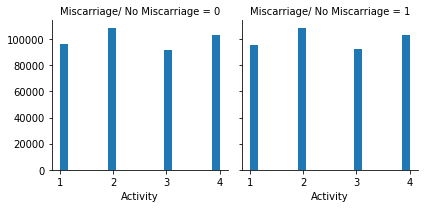

In [0]:
# Plotting
g = sns.FacetGrid(train, col='Miscarriage/ No Miscarriage')
g.map(plt.hist, 'Activity', bins=20)

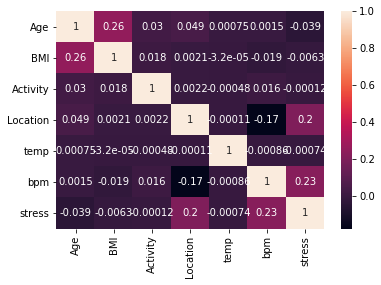

In [0]:
f = (
         data.loc[:, ['Age', 'BMI', 'Activity', 'Location','temp','bpm','stress']]
        .applymap(lambda v: int(v) if str else np.nan)
        .dropna()
).corr()

sns.heatmap(f, annot=True)

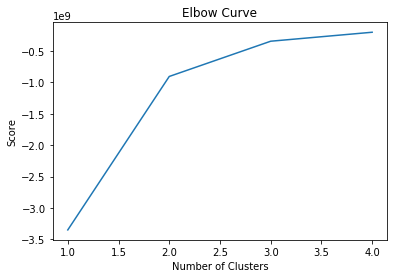

In [0]:
# get right number of cluster for K-means so we neeed to loop from 1 to 5 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 5)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#Found 3 Clusters

In [0]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

In [0]:
data['cluster'] = kmeans.labels_

In [0]:
data.loc[data.cluster == 0].count()

Age                            408180
BMI                            408180
Nmisc                          408180
Activity                       408180
Location                       408180
temp                           408180
bpm                            408180
stress                         408180
bp                             408180
Miscarriage/ No Miscarriage    408180
cluster                        408180
dtype: int64

In [0]:
sns.swarmplot(data.cluster,data.Activity)

In [0]:
# Parameters
X_data = np.array(train.drop(['Miscarriage/ No Miscarriage'], 1).astype(float))
y_data = np.array(train['Miscarriage/ No Miscarriage'])

num_steps = 120 # Total steps to train
k = 3 # The number of clusters
num_features = 9


In [0]:
# Input images
X = tf.placeholder(tf.float32, shape=[None, num_features]) # feed arbitrary number of X's 
Y = tf.placeholder(tf.int32, shape=[None,]) # feed Y's corresponding to the X
print(X)
print(Y)

Tensor("Placeholder_8:0", shape=(?, 9), dtype=float32)
Tensor("Placeholder_9:0", shape=(?,), dtype=int32)


In [0]:
from tensorflow.contrib.factorization import KMeans
# K-Means Parameters
kmeans = KMeans(inputs=X, num_clusters=k, distance_metric='cosine',
                use_mini_batch=True)

# Build KMeans graph
training_graph = kmeans.training_graph()

if len(training_graph) > 6: # Tensorflow 1.4+
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     cluster_centers_var, init_op, train_op) = training_graph
else:
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     init_op, train_op) = training_graph

cluster_idx = cluster_idx[0] # fix for cluster_idx being a tuple
avg_distance = tf.reduce_mean(scores)

# Initialize the variables (i.e. assign their default value)
init_vars = tf.global_variables_initializer()

In [0]:

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars, feed_dict={X: X_data})
sess.run(init_op, feed_dict={X: X_data})

# Training
for i in range(1, num_steps + 1):
    _, d, idx = sess.run([train_op, avg_distance, cluster_idx],
                         feed_dict={X: X_data})
    if i % 10 == 0 or i == 1:
        print("Step %i, Avg Distance: %f" % (i, d))

# Assign a label to each centroid
# Count total number of labels per centroid, using the label of each training
# sample to their closest centroid (given by 'idx')
counts = np.zeros(shape=(k, 2))
for i in range(len(idx)):
    counts[idx[i]] += 2
# Assign the most frequent label to the centroid
labels_map = [np.argmax(c) for c in counts]
labels_map = tf.convert_to_tensor(labels_map)

Step 1, Avg Distance: 0.003235
Step 10, Avg Distance: 0.002601
Step 20, Avg Distance: 0.002589
Step 30, Avg Distance: 0.002584
Step 40, Avg Distance: 0.002582
Step 50, Avg Distance: 0.002580
Step 60, Avg Distance: 0.002579
Step 70, Avg Distance: 0.002578
Step 80, Avg Distance: 0.002577
Step 90, Avg Distance: 0.002576
Step 100, Avg Distance: 0.002575
Step 110, Avg Distance: 0.002574
Step 120, Avg Distance: 0.002573


In [0]:

# Evaluation ops
# Lookup: centroid_id -> label
cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)
print(cluster_label)
# Compute accuracy
correct_prediction = tf.equal(cluster_label, tf.cast(Y, tf.int32))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# # Test Model
test_x, test_y = np.array(test.drop(['Miscarriage/ No Miscarriage'], 1).astype(float)),np.array(test['Miscarriage/ No Miscarriage'])
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

Tensor("embedding_lookup_2/Identity:0", dtype=int32)
Test Accuracy: 0.499145
